# Multi-step forecasting: recursive approach

In the previous notebooks, we predicted the hourly pollutant concentration for the next 24 hours utilizing a direct approach.

Here, we will carry out multi-step forecasting using a recursive approach.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import (
    CyclicalFeatures,
    MathFeatures,
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# We carry out all data preparation steps from the
# notebook in section 2 within a function.

def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [3]:
# Load data.

data = load_data()

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Our feature engineering class

In [4]:
class SeasonalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's
        # concentration per hour.

        # We make a copy of the dataframe
        # not to over-write the user's data.
        X = X.copy()

        # Calculate mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + "_season" for v in self.variables]

        # Reset index
        self.seasonal_ = self.seasonal_.reset_index()

        return self

    def transform(self, X):

        # Add the seasonal component to the
        # dataset to transform.

        X = X.copy()

        # Store the datetime index (it is lost in merge)
        index = X.index

        # Add the seasonal feature.
        X = X.merge(self.seasonal_, on=self.season_var, how="left")

        # Restore the datetime index to the df
        X.index = index

        # Drop input variable
        X = X.drop(self.variables, axis=1)

        return X

# Feature engineering steps

The same pipeline from the previous notebook.

In [5]:
# Datetime features
dtf = DatetimeFeatures(
    
    # the input dt variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [6]:
# Lag features.

lagf = LagFeatures(
    variables="CO_sensor",  # the input variable
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [7]:
# Window features

winf = WindowFeatures(
    variables="CO_sensor",  # the input variable
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [8]:
# Feature combination

combine = MathFeatures(
    # the variables to combine
    variables=["CO_sensor_lag_1H", "CO_sensor_lag_24H"],
    # we indicate we want the average
    func=["mean"],
    # the name of the new feature
    new_variables_names=["CO_lag_ave"],
    # what to do if the variables have NA
    missing_values="ignore",
)

In [9]:
# Periodic features

cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month", "hour"],
    # Whether to drop the original features.
    drop_original=False,
)

In [10]:
# Drop missing data
imputer = DropMissingData()

In [11]:
# Seasonal feature

seasonf = SeasonalTransformer(
    # the seasonal variable
    season_var="hour",
    # the time series
    variables=["CO_sensor"],
)

# Feature engineering pipeline

In [12]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("combine", combine),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("seasonal", seasonf),
    ]
)

# Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need data about the pollutant information at least 24 hours before to create the input features for the first day of the test set.

In [13]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp(
    "2005-03-04") - pd.offsets.Hour(24)]["CO_sensor"]

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [14]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_sensor_window_3H_mean,CO_lag_ave,month_sin,month_cos,hour_sin,hour_cos,CO_sensor_season
Date_Time,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,1224.0,1165.666667,1206.0,0.866025,-0.5,0.000000,1.000000,1039.513410
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,1215.0,1149.666667,1140.0,0.866025,-0.5,0.269797,0.962917,978.124528
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,1115.0,1084.000000,1057.0,0.866025,-0.5,0.519584,0.854419,918.704120
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,1124.0,991.666667,1017.5,0.866025,-0.5,0.730836,0.682553,880.855019
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,1028.0,927.666667,950.5,0.866025,-0.5,0.887885,0.460065,864.211111


In [15]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(6427,)


In [16]:
# Lasso regression

lasso = Lasso(random_state=0)

# Train the model

lasso.fit(X_train_t, y_train_t)

Lasso(random_state=0)

# Recursive multi-step forecasting: test set

We will forecast for 24 hours for various points in our dataset. 

We could do 24 hour forecasts for every point, or instead, we could forecast the next 24 hours at certain intervals. There are advantages and downsides to each method, which are beyond the scope of this course.

For simplicity, we will forecast 24 hours for every 24 hour interval.

In [17]:
# The first hour of forecast.

data_start = pd.Timestamp("2005-03-04")

In [18]:
# The last hour of forecast.

data_end = X_test.iloc[-1].name - pd.offsets.Hour(24)

data_end

Timestamp('2005-04-03 14:00:00')

In [19]:
# Each one of the forecasting start points.

pd.date_range(start=data_start, end=data_end, freq="24H")

DatetimeIndex(['2005-03-04', '2005-03-05', '2005-03-06', '2005-03-07',
               '2005-03-08', '2005-03-09', '2005-03-10', '2005-03-11',
               '2005-03-12', '2005-03-13', '2005-03-14', '2005-03-15',
               '2005-03-16', '2005-03-17', '2005-03-18', '2005-03-19',
               '2005-03-20', '2005-03-21', '2005-03-22', '2005-03-23',
               '2005-03-24', '2005-03-25', '2005-03-26', '2005-03-27',
               '2005-03-28', '2005-03-29', '2005-03-30', '2005-03-31',
               '2005-04-01', '2005-04-02', '2005-04-03'],
              dtype='datetime64[ns]', freq='24H')

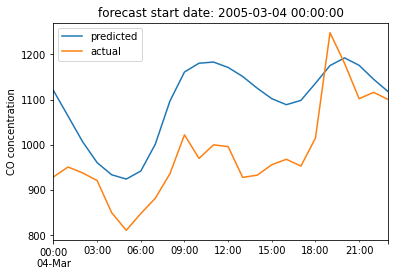

rmse:  132.6547276110267


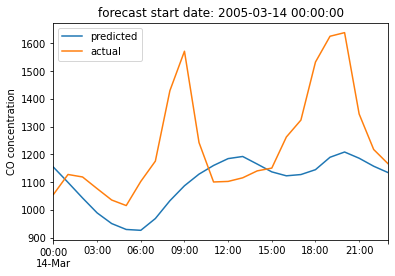

rmse:  218.68568299919198


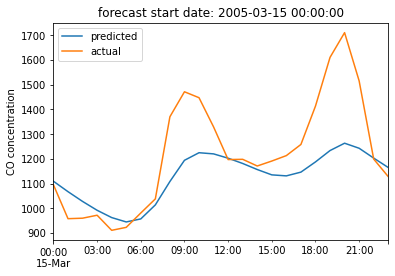

rmse:  173.05797761896403


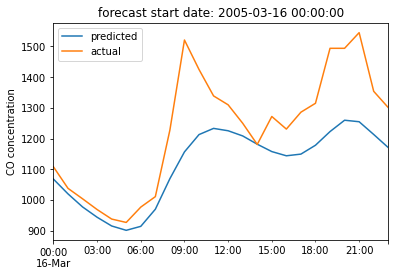

rmse:  149.98664038061344


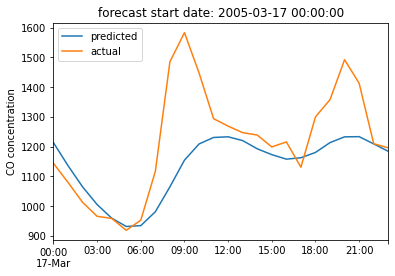

rmse:  157.5797091526809


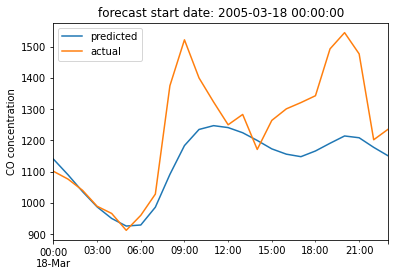

rmse:  159.31647395315835


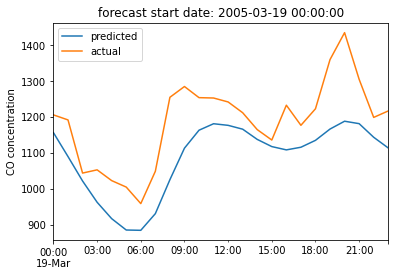

rmse:  116.0802283342707


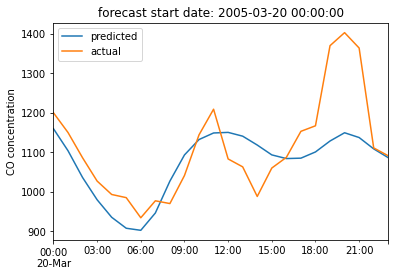

rmse:  100.26773202650855


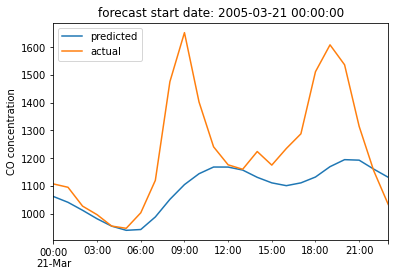

rmse:  216.1661733270334


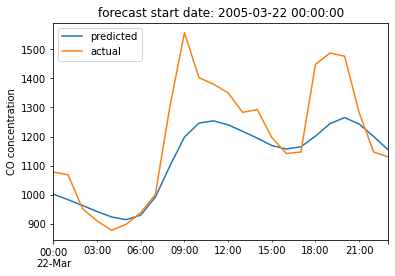

rmse:  132.8174641324076


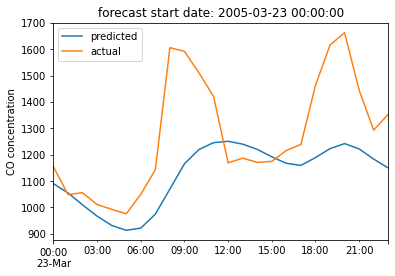

rmse:  221.28191567125404


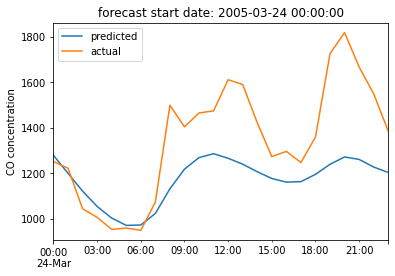

rmse:  245.4533116110643


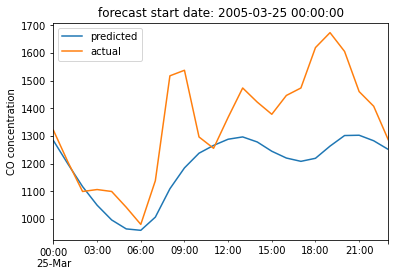

rmse:  203.4924504206187


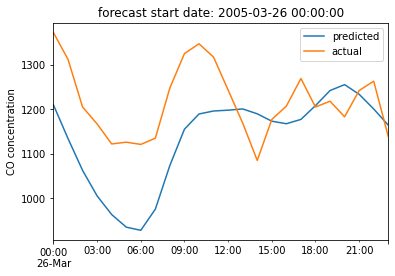

rmse:  122.73152039952636


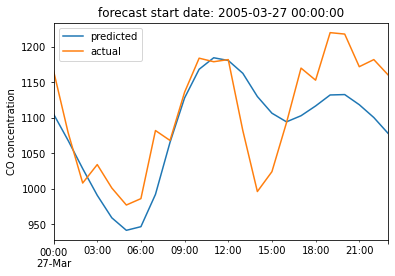

rmse:  60.4060403248452


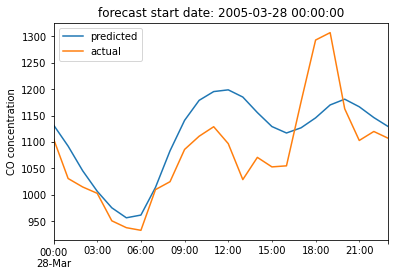

rmse:  71.48992990428906


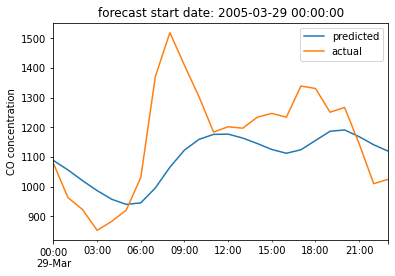

rmse:  164.65153959293198


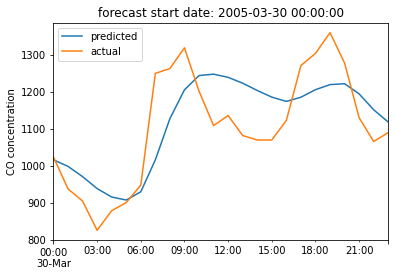

rmse:  101.25377131666505


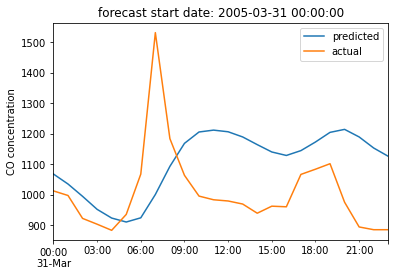

rmse:  197.6465508906356


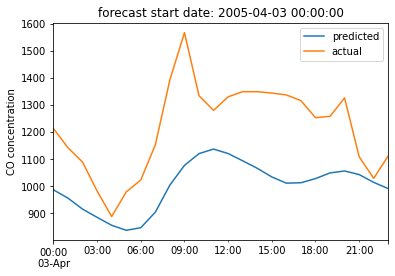

rmse:  238.53834900977495


In [20]:
# List to collect the RMSE for 
# each 24 hour forecast examined.

rmse_ls = []

# We forecast for every forecast start point:

for forecast_start in pd.date_range(start=data_start, end=data_end, freq="24H"):
    
    # The forecasting horizon.
    forecast_end = forecast_start + pd.offsets.Hour(23)

    # We need past data to create the features
    # for the first day of forecast.
    past_data = forecast_start - pd.offsets.Hour(24)
    
    # The timestamps at which we want to predict
    # pollutant concentration.
    index = pd.date_range(
        start=forecast_start,
        end=forecast_end,
        freq="1H",
    )
    
    # Take input data to obtain the first prediction value.

    f_horizon = X_test[
        (X_test.index >= past_data) &
        (X_test.index < forecast_start)
    ]
    
    # Check that we have 24 hours of past data:
    if len(f_horizon)==24:

        # Add the forecasting horizon.
        f_horizon = pd.concat([f_horizon, pd.DataFrame(index=index)], axis=0)

        # Check that we have values in the target to corroborate
        # our 24 hours forecast.
        tmp = X_test[
            (X_test.index >= forecast_start) &
            (X_test.index <= forecast_end)
        ]
        
        if len(tmp)==24:

            # Let's obtain the first prediction.
            pred = lasso.predict(pipe.transform(f_horizon))[0]

            # Add the prediction to the horizon.
            f_horizon.loc[forecast_start] = pred

            # ===================
            # Now we use the prediction as input to make
            # the prediction in the following hour.

            # And we repeat the process 23 times:

            for i in range(24):

                # Re-slice the horizon.
                f_horizon = f_horizon[f_horizon.index >= past_data + pd.offsets.Hour(i)]

                # Obtain the prediction
                pred = lasso.predict(pipe.transform(f_horizon))[0]

                # Add prediction to horizon.
                f_horizon.loc[forecast_start+pd.offsets.Hour(i)] = pred

            # Re-slice the horizon.
            f_horizon = f_horizon[f_horizon.index >= past_data + pd.offsets.Hour(i+1)]


            # Join predictions and real values.
            tmp = f_horizon.join(X_test["CO_sensor"], lsuffix="_left", rsuffix="_right")

            # Rename columns in dataframe.
            tmp.columns = ["predicted", "actual"]

            tmp.plot()
            plt.ylabel("CO concentration")
            plt.title(f"forecast start date: {forecast_start}")
            plt.show()

            # Determine the RMSE.
            rmse_ = mean_squared_error(
                y_true=tmp["actual"],
                y_pred=tmp["predicted"],
                squared=False,
            )
            print("rmse: ", rmse_)

            # Append the RMSE to our list.
            rmse_ls.append(rmse_)

In [21]:
# Mean performance across all 24 hr forecast

print("rmse: ", np.mean(rmse_ls), "+-", np.std(rmse_ls))
print("Number of days evaluated: ", len(rmse_ls))

rmse:  159.17790943387303 +- 53.383206314009676
Number of days evaluated:  20


This model seems to capture the seasonality better because a lot of the time features contribute substantially to the prediction.